# Exercise Session: Logistic Regression
$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\Yb}{\mathbf{Y}}$
$\DeclareMathOperator*{\argmin}{argmin}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# project files
import sys
sys.path.append('..')
import helpers as helpers

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# 1 Introduction

This week's exercise is about linear classification, in particular, logistic regression. We will focus on the binary classification scenario, i.e., two classes.

# 2 Binary Classification with Logistic Regression

Let's start by loading the [_Iris Flower Dataset_](https://en.wikipedia.org/wiki/Iris_flower_data_set). To facilitate visualization, we will only use 2 out of the 4 features of this dataset. Furthermore, we will use 2 out of the 3 classes in this dataset, named *setosa* and *versicolor*. Therefore, for this part our dataset with two classes is as follows:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 

Note that $\Xb$ is a matrix of shape $(N \times (D+1))$. However, a single data sample $\xb_i$ is a column vector of shape $((D+1) \times 1)$. 
To compute a scalar product of one data sample with the weight vector $\wb$ (also a column vector of shape $((D+1) \times 1)$), we write $\xb_i^\top\cdot\wb$. To perform a matrix-vector multiplication of the entire data matrix with the weight vector, we write $\Xb\cdot\wb$.

<IPython.core.display.Javascript object>


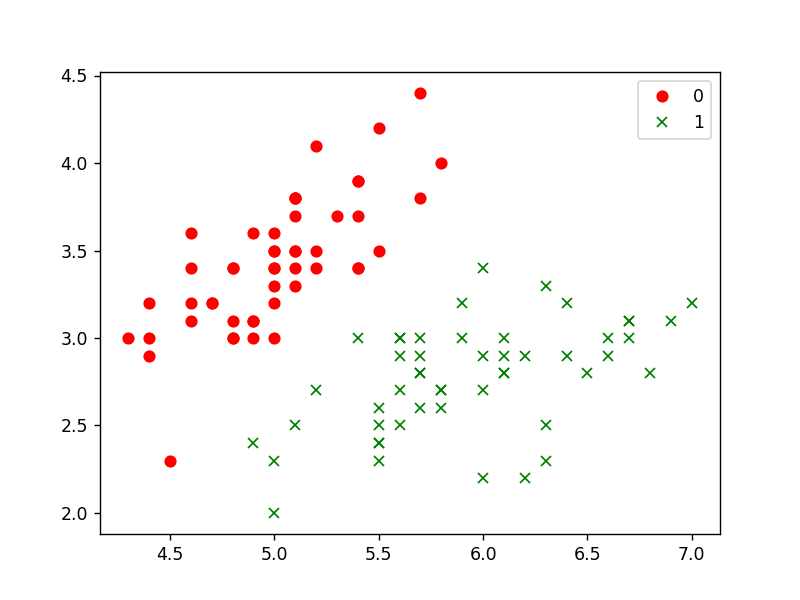

In [2]:
# Loads the data and split them into training and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=True, versicolor=True, virginica=False, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  

## 2.1 Short introduction

In logistic regression, the probability (score) that a data point belongs to the positive class is expressed as
$$P(y_i=1|\xb_i, \wb) = \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}} $$

This relies on the sigmoid function is defined as
$$\sigma(t)= \frac{1}{1+e^{-t}}$$

So in our case, the prediction of our model is defined as
$$\hat{y}(\xb_i)=\sigma(\xb_i^{\top}\cdot \wb)= \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}}$$

Let us code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [3]:
def sigmoid(t):
    """ Sigmoid function
    
    Args:
        t (np.array): Input data of shape (N, )
        
    Returns:
        np.array: Probabilites of shape (N, ), where each value is in [0, 1].
    """
    return 1/(1+np.exp(-t))

Recall that the cross entropy loss is defined as:
$$
R(\wb) = -\sum_i (y_i \log(\hat{y}(\xb_i)) + (1-y_i)\log(1-\hat{y}(\xb_i))) $$

Let's code it using NumPy. If you do it correctly, it can be written in one line!

In [6]:
def loss_logistic(data, labels, w): 
    """ Logistic regression loss function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        int: Loss of logistic regression.
    """
    
    return np.sum((labels - 1) * np.log(1 - sigmoid(data@w))) - np.sum(labels * np.log(sigmoid(data@w)))

#print(loss_logistic(data_train, labels_train, np.linalg.pinv(data_train) @ labels_train))

To move the weight vector towards the optimal weights, we need to compute the gradient of the loss function. This gradient is defined as
$$\nabla R(\wb)= \sum_i (\hat{y}(\xb_i) - y_i)\xb_i $$
Let us put this into a nice matrix format:
$$\nabla R(\wb)= \Xb^\top(\hat{y}(\Xb) - \yb) = \Xb^\top(\sigma(\Xb\cdot \wb) - \yb),
$$

where $\hat{y}(\Xb) = \sigma(\Xb\cdot \wb)$ and $\sigma(\Xb\cdot \wb)$ computes the sigmoid for each data sample separately, and returns a vector of shape $(N \times 1)$.

Fill in the function for computing the gradient `gradient_logistic()`. You can use the numpy function `np.dot()` or an operator `@` for matrix multiplication.

In [17]:
def gradient_logistic(data, labels, w):
    """ Logistic regression gradient function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np. array: Gradient array of shape (D, )
    """
    return data.T @ (sigmoid(data @ w) - labels)
print(gradient_logistic(data_train, labels_train, np.linalg.pinv(data_train) @ labels_train))

[ 9.66207541 70.37848266 30.25209347]


## 2.2 Classification using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_classify()`. This function uses the weights we find during training to predict the labels for the data.

**Hints:**
* We classify our data according to $P(y_i=1|\xb_i, \wb)$. If the value of $P(y_i=1|\xb_i, \wb)$ is less than 0.5 then the data point is classified as label 0. If it is more than or equal to 0.5 then we classify the data point as label 1.

In [18]:
def logistic_regression_classify(data, w):
    """ Classification function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np.array: Label assignments of data of shape (N, )
    """
    #### write your code here: find predictions and threshold.
    predictions = (sigmoid(data @ w) > 0.5).astype(int)
     
    return predictions
print(logistic_regression_classify(data_test, np.linalg.pinv(data_train) @ labels_train))
print(labels_test)

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
[1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1]


We measure the performance of our classifier with *accuracy* metric. It is defined as $$ f_{\text{acc}} = \frac{\text{# correct predictions}}{\text{# all predictions}}$$
Implement the following `accuracy()` function using the predicted and ground truth labels.

In [9]:
def accuracy(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    
    
    return np.equal(labels_gt, labels_pred).astype(int).sum()/labels_pred.size
print(accuracy(logistic_regression_classify(data_test, np.linalg.pinv(data_train) @ labels_train), labels_test))

0.7


## 2.3 Training a logistic regression model

To find the optimal weights for the given training data, we need to train our model. Fill in the missing parts of the function `logistic_regression_train()`.

The function first initializes the weights randomly (according to a Gaussian distribution). In each iteration, you should compute the gradient using `gradient_logistic` and take a gradient step to update the weights. Given that $\eta$ is the learning rate, recall that a gradient step is expressed as: $$ \wb_{[t + 1]}  = \wb_{[t]} - \eta \nabla R(\wb_{[t]}) $$

The `loss`, `plot` and `print_every` parameters affect the way the loss is printed and the predictions are displayed. You do not need to modify these parts.



In [11]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, 
                              print_period=1000, plot_period=1000):
    """ Training function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        np.array: weights of shape(D, )
    """

    #initialize the weights randomly according to a Gaussian distribution
    weights = np.random.normal(0., 0.1, [data.shape[1],])
    for it in range(max_iters):
        ########## write your code here: find gradient and do a gradient step
        gradient = gradient_logistic(data, labels, weights)
        weights = weights - lr * gradient
        ##################################
        predictions = logistic_regression_classify(data, weights)
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
            plt.title("iteration "+ str(it))
        if accuracy(labels, predictions) == 1:
            break
    fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
    plt.title("iteration "+ str(it))
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

loss at iteration 0 : 118.30493821407711


<IPython.core.display.Javascript object>


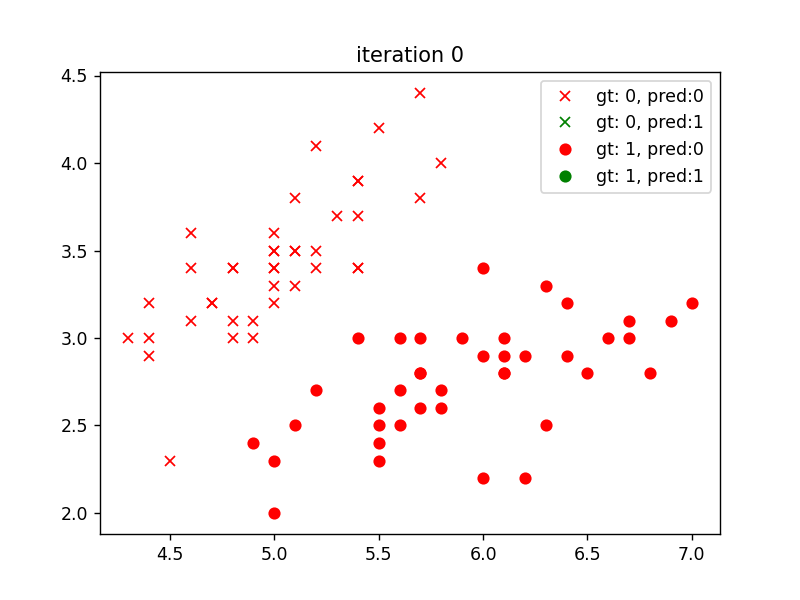

loss at iteration 1000 : 3.984428796134773
loss at iteration 2000 : 3.469118478543816
loss at iteration 3000 : 3.075536839022091


<IPython.core.display.Javascript object>


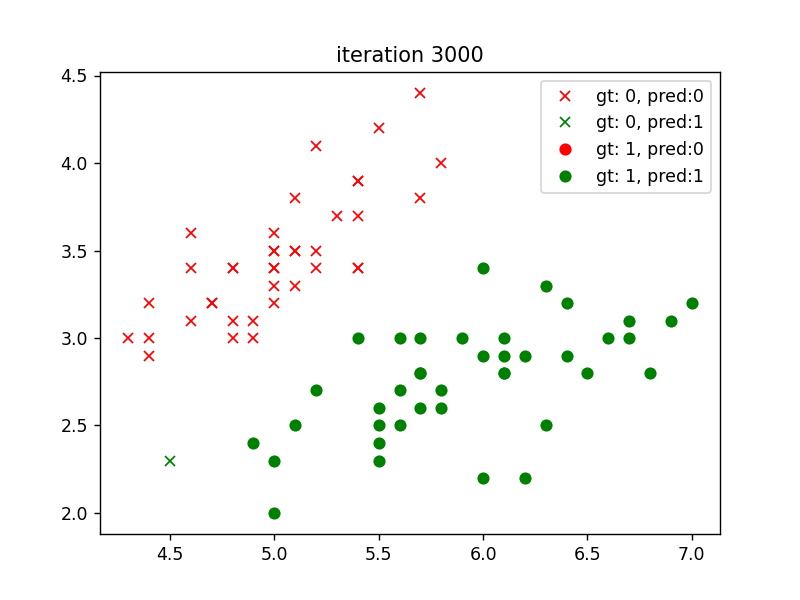

loss at iteration 4000 : 2.7552883314439343
loss at iteration 5000 : 2.491251973407717
loss at iteration 6000 : 2.2719672550084047


<IPython.core.display.Javascript object>


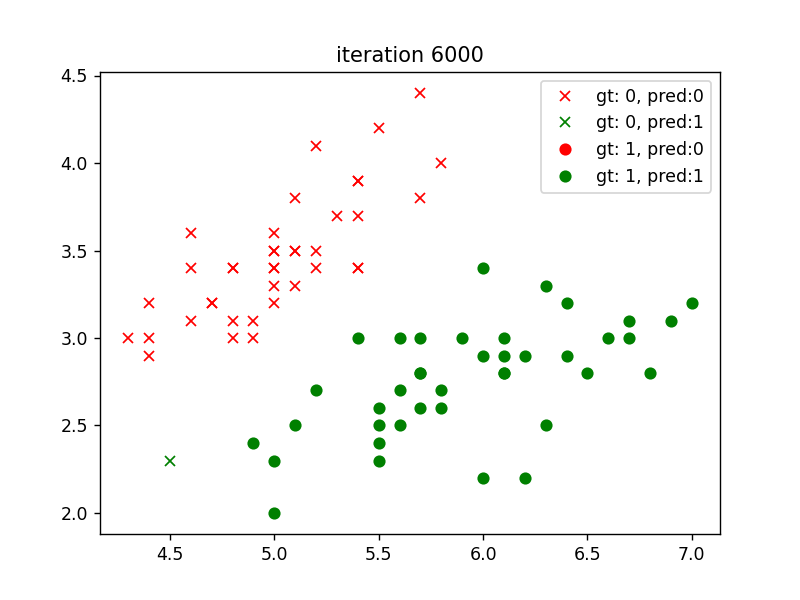

loss at iteration 7000 : 2.088314554762586
loss at iteration 8000 : 1.9329998983274184
loss at iteration 9000 : 1.8002988337500447


<IPython.core.display.Javascript object>


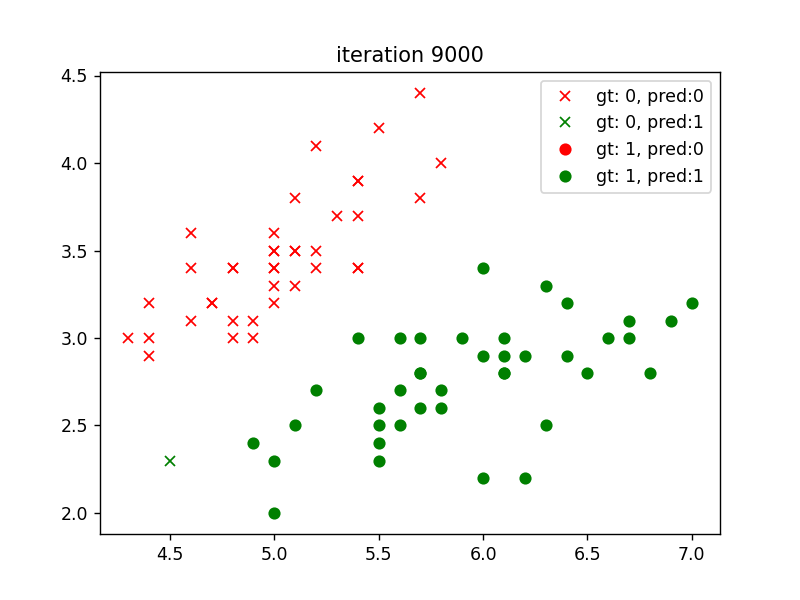

loss at iteration 10000 : 1.6857723498333739
loss at iteration 11000 : 1.5859881917102472
loss at iteration 12000 : 1.4982834002161394


<IPython.core.display.Javascript object>


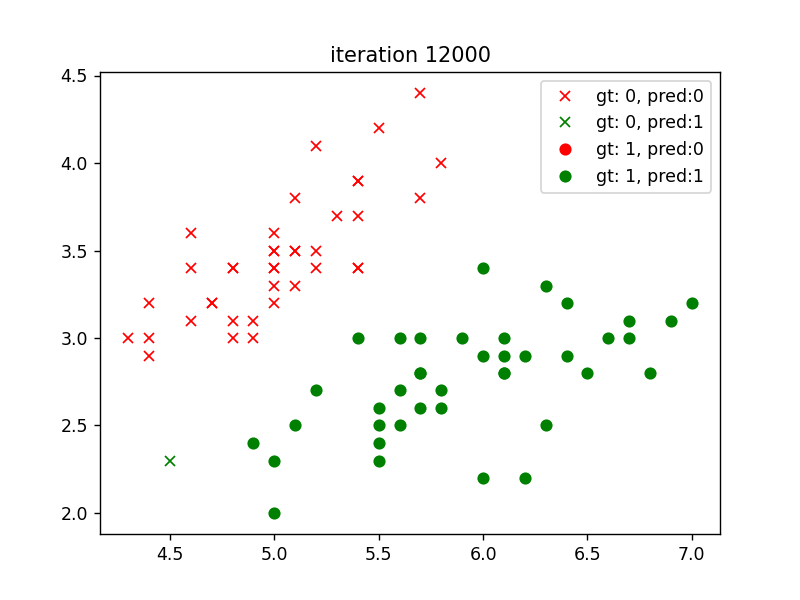

<IPython.core.display.Javascript object>


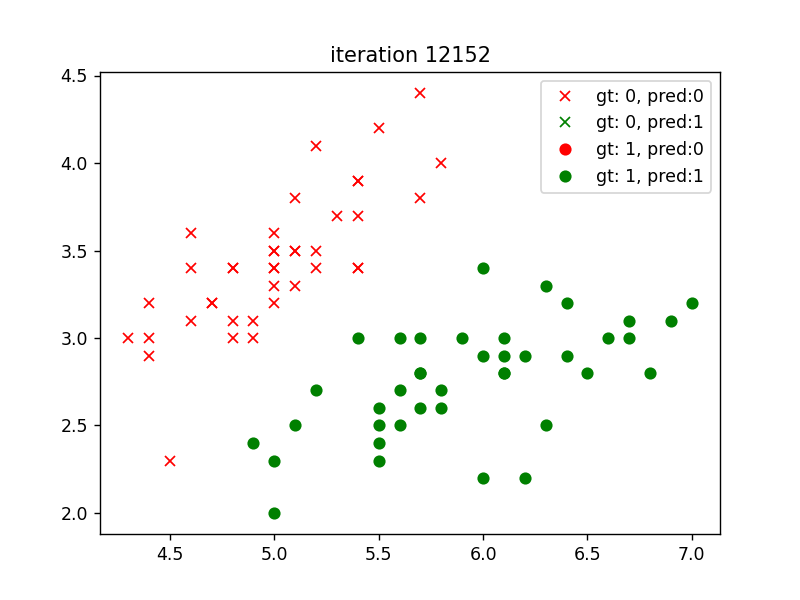

In [12]:
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-2, print_period=1000, plot_period=3000)

<IPython.core.display.Javascript object>


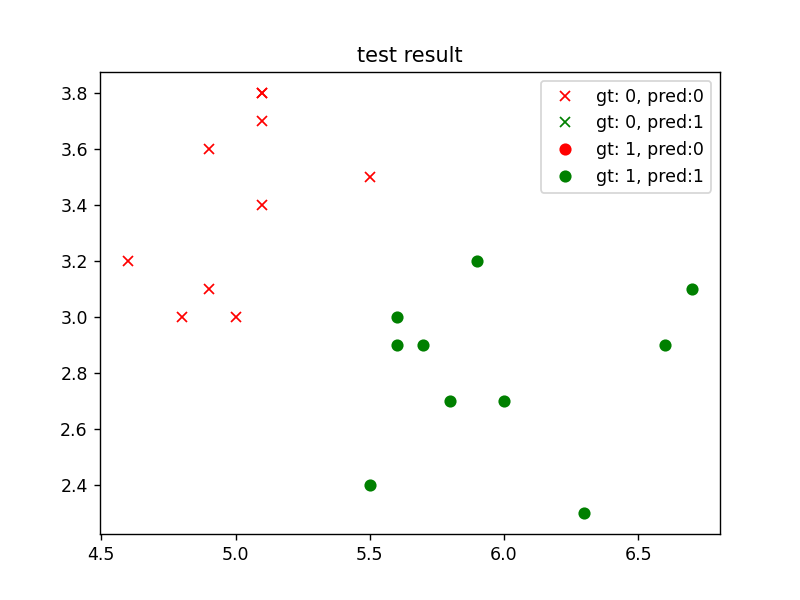

Accuracy is 1.0


In [13]:
predictions = logistic_regression_classify(data_test, weights)
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")
print("Accuracy is", accuracy(labels_test, predictions))

# 3 Different Data

Let us now use the same dataset, with the same 2 features as before, but change the 2 classes to *versicolor* and *virginica*. As we use the features and the same number of classes, our dataset as the same form as before:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 


<IPython.core.display.Javascript object>


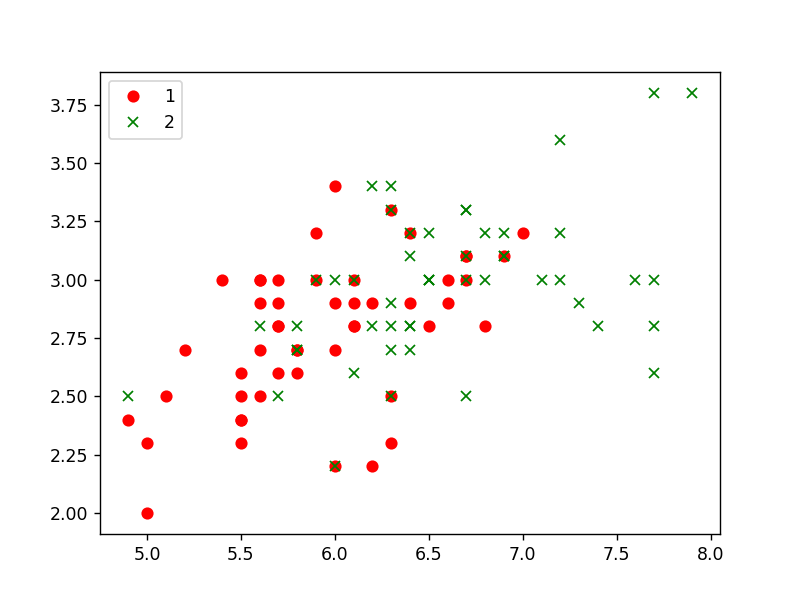

In [14]:
# Loads the data and split them into trian and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=False, versicolor=True, virginica=True, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  
labels_train[labels_train==2] = 0

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  
labels_test[labels_test==2] = 0




Now you can perform training and evaluation on this dataset. We leave this part to you. 
Note: We recommend reducing the plotting period of the `logistic_regression_train` function.

loss at iteration 0 : 180.9819512367124


<IPython.core.display.Javascript object>


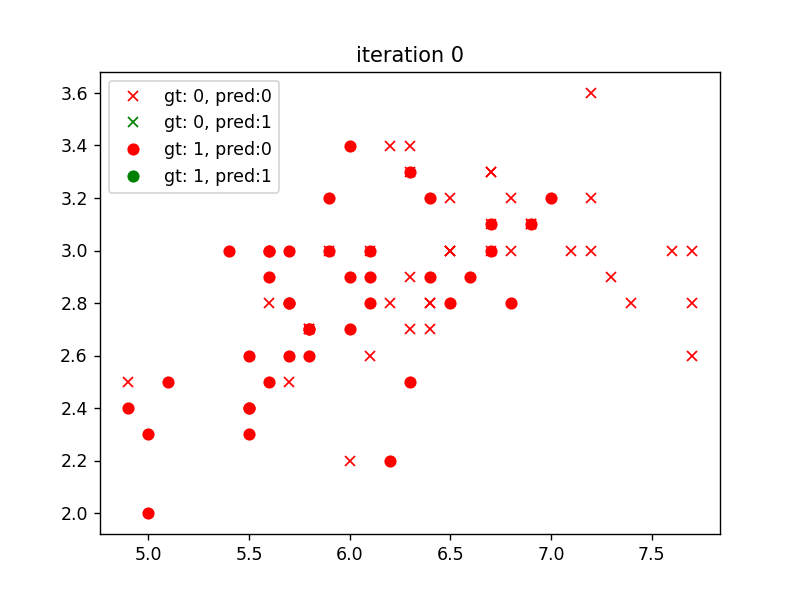

loss at iteration 1000 : 287.3164108250142
loss at iteration 2000 : 256.31262309247705
loss at iteration 3000 : 244.54959727126416
loss at iteration 4000 : 230.8224812273885
loss at iteration 5000 : 216.36585665444906
loss at iteration 6000 : 202.52904098037567
loss at iteration 7000 : 193.23421431817766
loss at iteration 8000 : 188.35221426813732
loss at iteration 9000 : 185.6208141096191
loss at iteration 10000 : 183.98563921814943


<IPython.core.display.Javascript object>


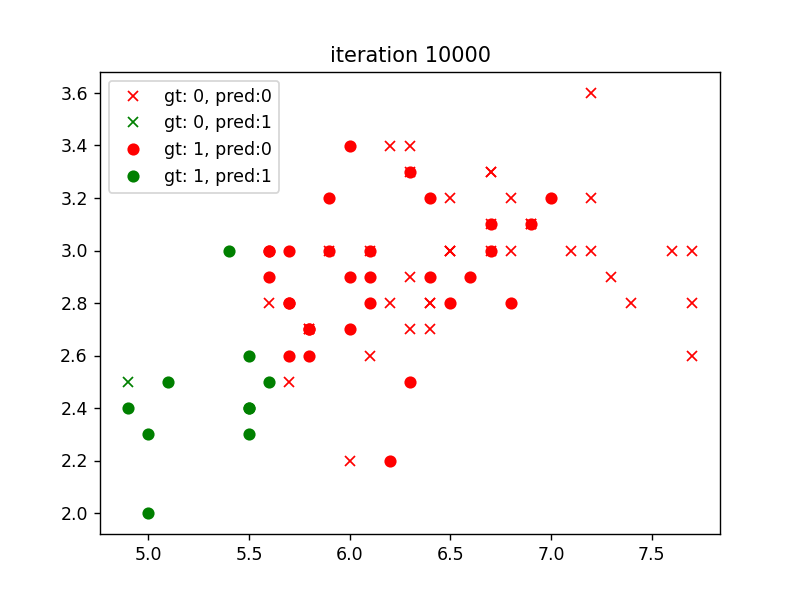

loss at iteration 11000 : 182.98463621433652
loss at iteration 12000 : 182.3691853494494
loss at iteration 13000 : 181.99102311281862
loss at iteration 14000 : 181.75902259745183
loss at iteration 15000 : 181.61688720478136
loss at iteration 16000 : 181.52989476689314
loss at iteration 17000 : 181.47668762974257
loss at iteration 18000 : 181.44415861020252
loss at iteration 19000 : 181.42427688637363
loss at iteration 20000 : 181.4121272393411


<IPython.core.display.Javascript object>


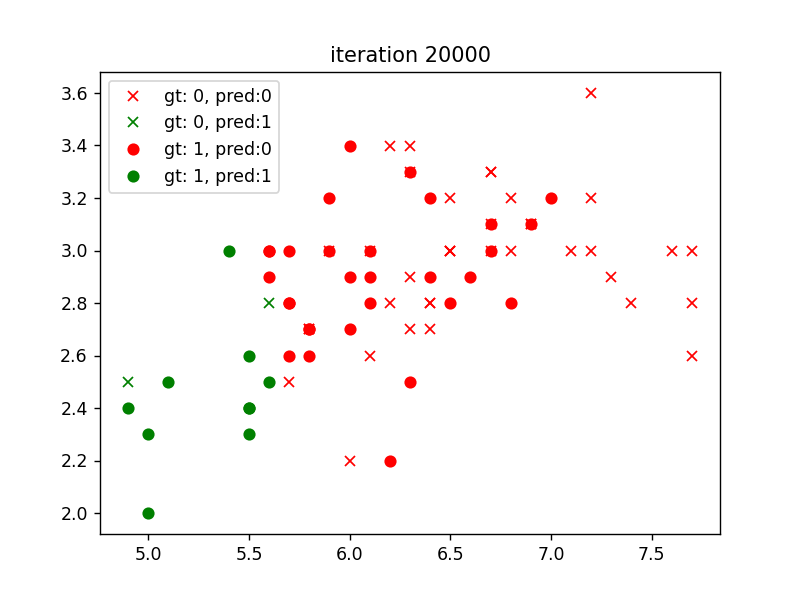

loss at iteration 21000 : 181.40470341102932
loss at iteration 22000 : 181.40016750262456
loss at iteration 23000 : 181.39739620278337
loss at iteration 24000 : 181.39570306510225
loss at iteration 25000 : 181.39466865055388
loss at iteration 26000 : 181.3940366855319
loss at iteration 27000 : 181.39365059507557
loss at iteration 28000 : 181.39341471914477
loss at iteration 29000 : 181.3932706147279
loss at iteration 30000 : 181.39318257667938


<IPython.core.display.Javascript object>


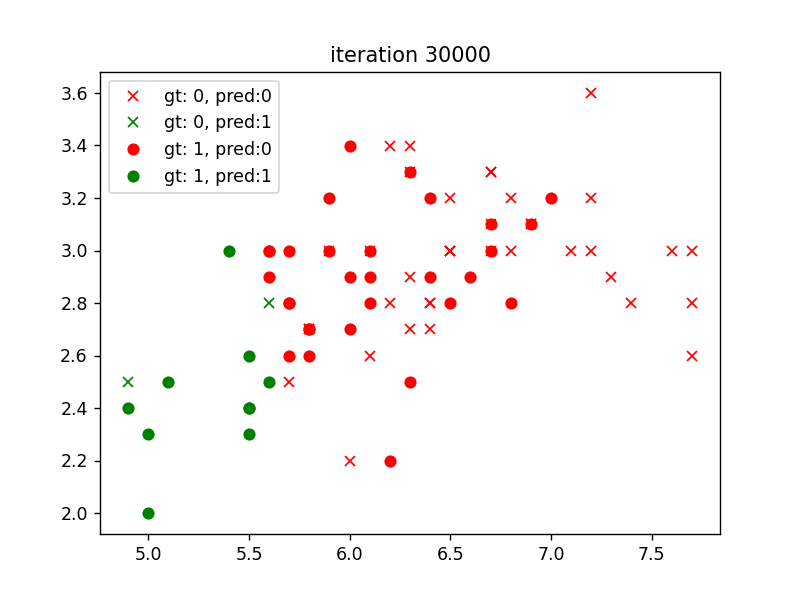

loss at iteration 31000 : 181.39312879142878
loss at iteration 32000 : 181.39309593232062
loss at iteration 33000 : 181.39307585765923
loss at iteration 34000 : 181.39306359342038
loss at iteration 35000 : 181.39305610081365
loss at iteration 36000 : 181.3930515233467
loss at iteration 37000 : 181.3930487268292
loss at iteration 38000 : 181.39304701834982
loss at iteration 39000 : 181.39304597458602
loss at iteration 40000 : 181.39304533691862


<IPython.core.display.Javascript object>


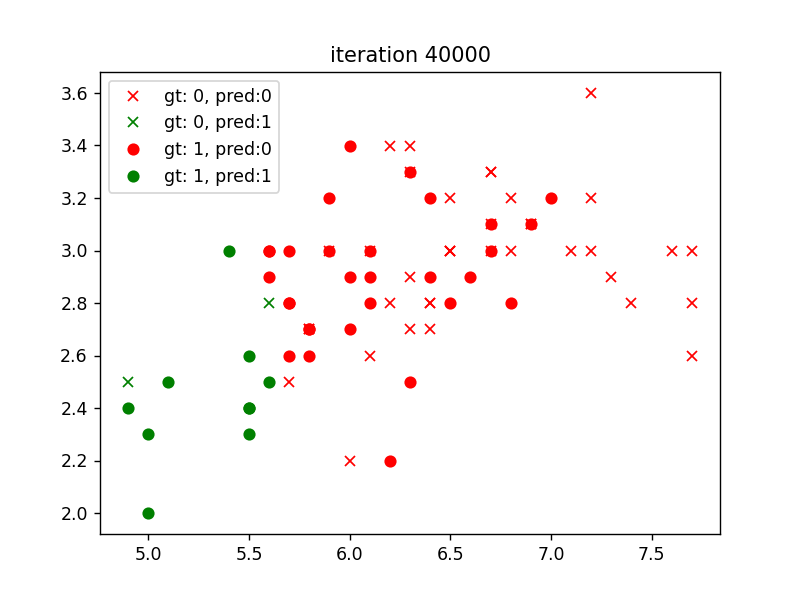

loss at iteration 41000 : 181.39304494734762
loss at iteration 42000 : 181.3930447093471
loss at iteration 43000 : 181.39304456394456
loss at iteration 44000 : 181.39304447511358
loss at iteration 45000 : 181.39304442084403
loss at iteration 46000 : 181.39304438768917
loss at iteration 47000 : 181.39304436743373
loss at iteration 48000 : 181.39304435505906
loss at iteration 49000 : 181.39304434749934
loss at iteration 50000 : 181.39304434288007


<IPython.core.display.Javascript object>


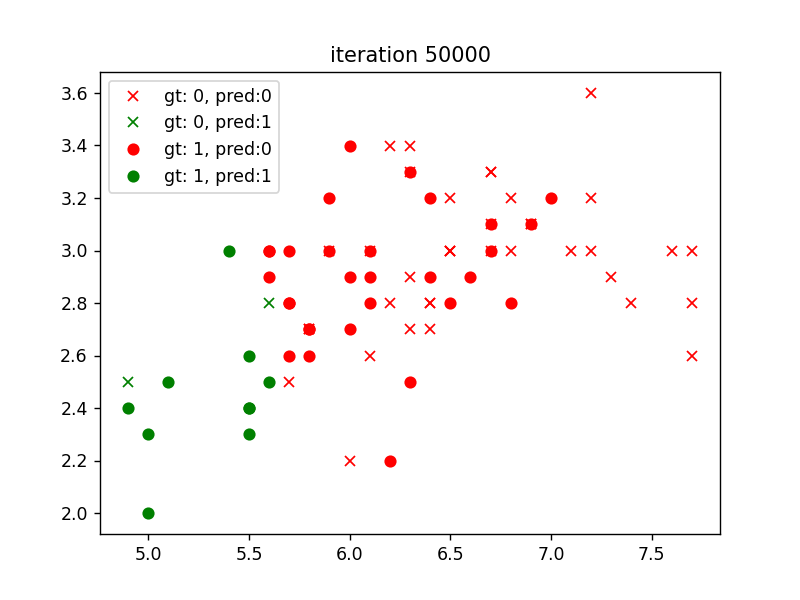

loss at iteration 51000 : 181.39304434005922
loss at iteration 52000 : 181.3930443383354
loss at iteration 53000 : 181.39304433728194
loss at iteration 54000 : 181.39304433663864
loss at iteration 55000 : 181.3930443362457
loss at iteration 56000 : 181.39304433600577
loss at iteration 57000 : 181.3930443358592
loss at iteration 58000 : 181.39304433577024
loss at iteration 59000 : 181.39304433571553
loss at iteration 60000 : 181.39304433568356


<IPython.core.display.Javascript object>


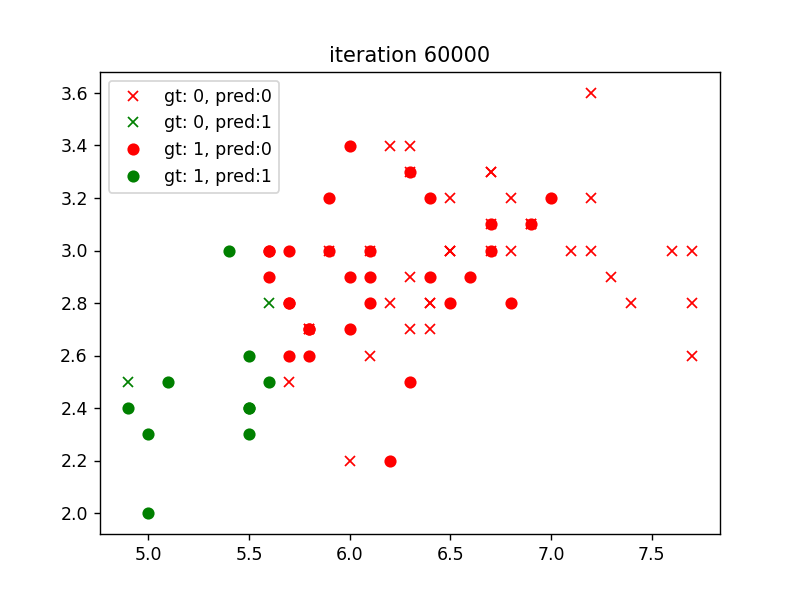

loss at iteration 61000 : 181.3930443356681
loss at iteration 62000 : 181.39304433565212
loss at iteration 63000 : 181.39304433564837
loss at iteration 64000 : 181.39304433564845
loss at iteration 65000 : 181.39304433564845
loss at iteration 66000 : 181.39304433564845
loss at iteration 67000 : 181.39304433564845
loss at iteration 68000 : 181.39304433564845
loss at iteration 69000 : 181.39304433564845
loss at iteration 70000 : 181.39304433564845


<IPython.core.display.Javascript object>


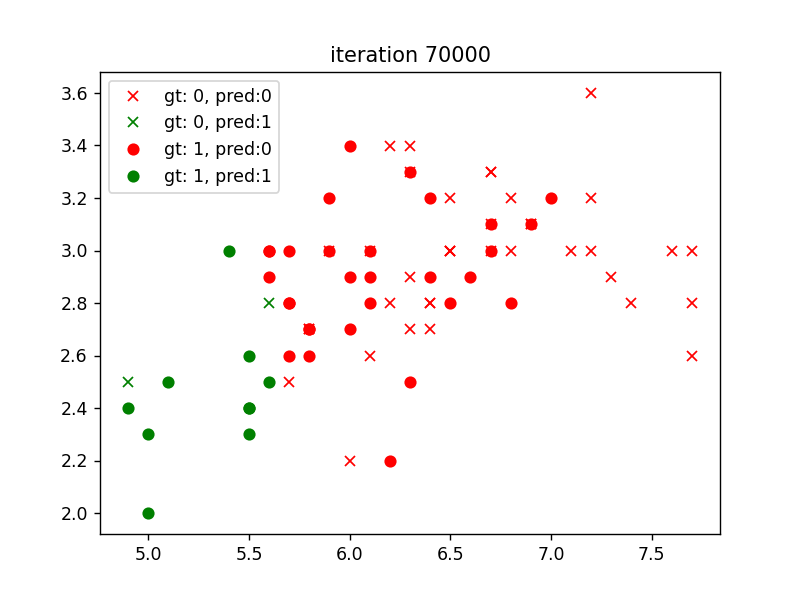

loss at iteration 71000 : 181.39304433564845
loss at iteration 72000 : 181.39304433564845
loss at iteration 73000 : 181.39304433564845
loss at iteration 74000 : 181.39304433564845
loss at iteration 75000 : 181.39304433564845
loss at iteration 76000 : 181.39304433564845
loss at iteration 77000 : 181.39304433564845
loss at iteration 78000 : 181.39304433564845
loss at iteration 79000 : 181.39304433564845
loss at iteration 80000 : 181.39304433564845


<IPython.core.display.Javascript object>


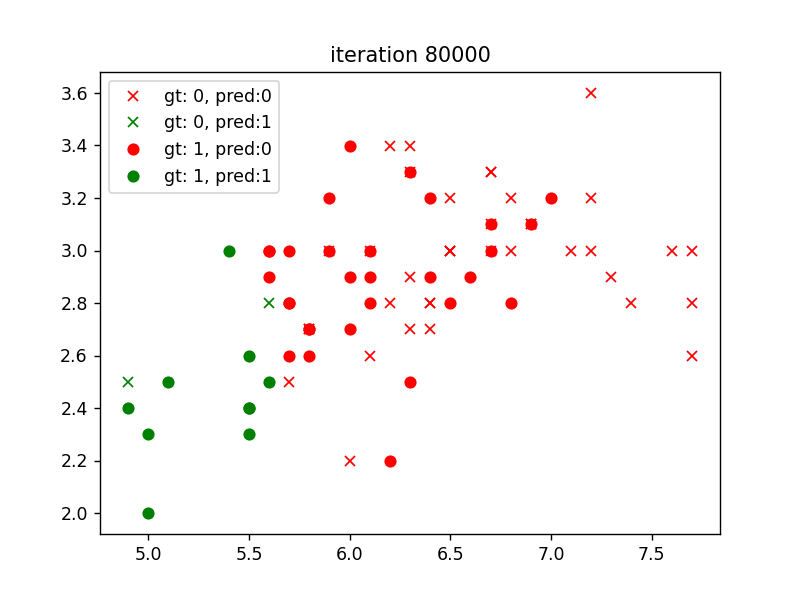

loss at iteration 81000 : 181.39304433564845
loss at iteration 82000 : 181.39304433564845
loss at iteration 83000 : 181.39304433564845
loss at iteration 84000 : 181.39304433564845
loss at iteration 85000 : 181.39304433564845
loss at iteration 86000 : 181.39304433564845
loss at iteration 87000 : 181.39304433564845
loss at iteration 88000 : 181.39304433564845
loss at iteration 89000 : 181.39304433564845
loss at iteration 90000 : 181.39304433564845


<IPython.core.display.Javascript object>


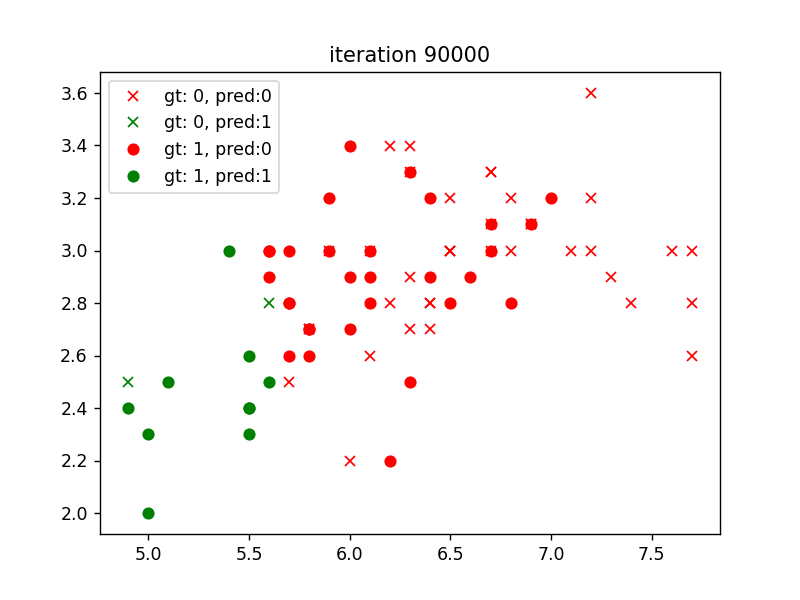

loss at iteration 91000 : 181.39304433564845
loss at iteration 92000 : 181.39304433564845
loss at iteration 93000 : 181.39304433564845
loss at iteration 94000 : 181.39304433564845
loss at iteration 95000 : 181.39304433564845
loss at iteration 96000 : 181.39304433564845
loss at iteration 97000 : 181.39304433564845
loss at iteration 98000 : 181.39304433564845
loss at iteration 99000 : 181.39304433564845


<IPython.core.display.Javascript object>


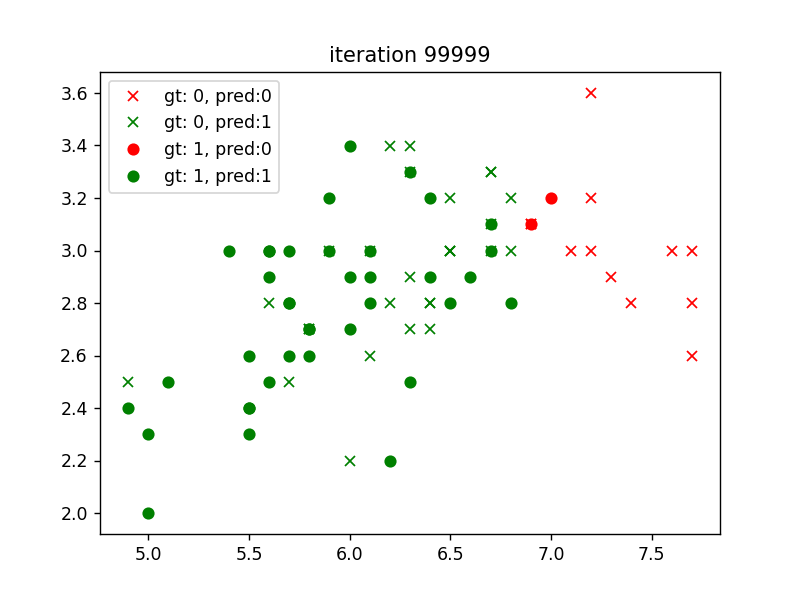

/mnt/c/Users/abehs/OneDrive/@Academics/btrois_epfl/cs233. IntroML/Week 4/exercise/helpers.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, _ = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


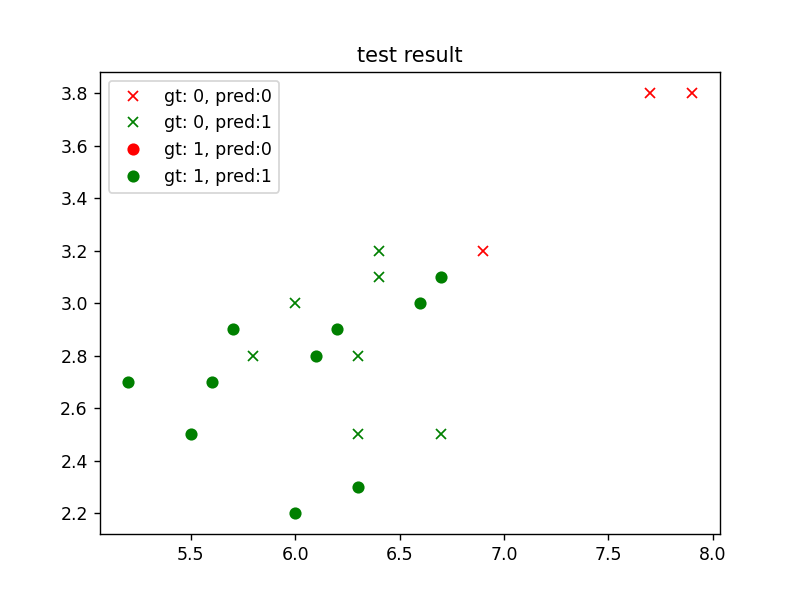

Test Accuracy is 0.65


In [19]:
#Train
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-2, print_period=1000, plot_period=10000)
#Predict
predictions = logistic_regression_classify(data_test, weights)

fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")

#Calculate accuracy
test_accuracy = accuracy(labels_test, predictions)
print("Test Accuracy is", test_accuracy)

**Q: Comment on the accuracy. What is the difference between the dataset  in the first part and this one?**
 

In [13]:
#The accuracy is much lower. The samples of the dataset in the first part are clearly separable, while they are not at all in this one.